In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import plotly as py
from chart_studio.plotly import plot_mpl
import plotly.graph_objects as go

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima import arima
from pmdarima.arima import auto_arima
from pmdarima import pipeline, preprocessing as ppc, utils

%matplotlib inline

In [2]:
def sarima_fit_predict (train, endog_col, periods, exog_cols = None):
    
    y_train = train[endog_col]
    
    if exog_cols:
        
        exog_train = train[exog_cols]
        
        model = auto_arima(y_train, exogenous= exog_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=52,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
        
        print(f"Final AIC: {model.aic()}")
        print(model)
        preds, conf_int = model.predict(n_periods = periods, exogenous = exog_train, return_conf_int = True)
    
    else:
        
        model = auto_arima(y_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=52,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
        
        print(f"Final AIC: {model.aic()}")
        print(model)
        preds, conf_int = model.predict(n_periods = periods, return_conf_int = True)
        
    return model, preds, conf_int

In [3]:
def sarima_update(test, split, model):
    
    # We can also call `update` directly on the pipeline object, which will update
    # the intermittent transformers, where necessary:
    observed, val_test = test[:split], test[split:]
    model.update(observed, maxiter=10)
    
    preds, conf = model.predict(n_periods = val_test.shape[0], return_conf_int= True)
    
    return preds, conf, observed, val_test

In [4]:
def plotly_forecast(df, preds, train, test):
    
    # Create traces
    fig = go.Figure()

    n_train = train.shape[0]
    x = np.arange(n_train + preds.shape[0])

    fig.add_trace(go.Scatter(x= df.index[n_train:], y= preds,
                    mode='lines+markers',
                    name='Predicted'))

    fig.add_trace(go.Scatter(x= df.index[n_train:], y= test[:preds.shape[0]],
                    mode='lines+markers',
                    name='Actual'))


    fig.show()

In [63]:
moraine = pd.read_csv( "../data/Site-Data/moraine_agg.csv")

In [64]:
moraine['Date'] = pd.to_datetime(moraine['Date']) - pd.to_timedelta(7, unit='d')
moraine.index = pd.DatetimeIndex(moraine['Date'])
moraine = moraine.groupby([pd.Grouper(key='Date', freq='W-MON')]).mean().sort_values('Date')
moraine.head()

,FacilityID,Reservations,NumberOfPeople,SitesBooked,AvgStayLen,AvgBookingHorizon,AverageFee,DailyRevenue,SumHor,SumLen,SumFee,SitesAvailable,PercentBooked
Date,,,,,,,,,,,,,
2014-05-19,232463.0,225.200000,766.000000,149.000000,3.242773,59.978610,30.365414,2368.088086,14203.399551,733.200004,6830.000014,102.000000,0.593625
2014-05-26,232463.0,195.571429,616.714286,148.714286,3.538806,48.377871,38.719400,2181.585013,9670.571438,684.714282,7507.142780,102.285714,0.592487
2014-06-02,232463.0,263.285714,794.285714,183.000000,3.573867,54.106416,36.268623,2816.787423,15040.285890,930.142854,9288.571557,68.000000,0.729084
2014-06-09,232463.0,367.000000,1050.714286,235.714286,3.526888,55.617553,36.648424,3994.855399,20875.285633,1287.999992,13364.285431,15.285714,0.939101
2014-06-16,232463.0,321.571429,1075.428571,197.857143,3.711821,76.349417,40.272182,3617.644531,24702.999919,1191.428576,12917.142714,53.142857,0.788275


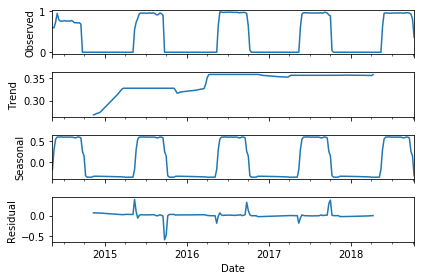

In [65]:
result = seasonal_decompose(moraine['PercentBooked'], model='additive')
fig = result.plot()

In [66]:
train, test = moraine[:170], moraine[170:]

y_train, y_test = train['PercentBooked'], test['PercentBooked']
exog_train = train[['Reservations', 'NumberOfPeople', 'AvgStayLen', 'AvgBookingHorizon', 'DailyRevenue']]
exog_test = test[['Reservations', 'NumberOfPeople', 'AvgStayLen', 'AvgBookingHorizon', 'DailyRevenue']]

In [67]:
y_train = y_train + 1e-16

In [68]:
a = 0
b = 1

fit  = np.log((y_train - a)/(b - y_train))

In [86]:
model = auto_arima(fit, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=52,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=784.134, BIC=789.658, Fit time=0.153 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 52); AIC=782.071, BIC=793.120, Fit time=2.255 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=780.087, BIC=788.373, Fit time=0.305 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 0, 52); AIC=781.165, BIC=792.214, Fit time=0.463 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 52); AIC=758.604, BIC=769.653, Fit time=2.265 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 0, 52); AIC=761.257, BIC=777.830, Fit

In [87]:
preds, conf_int = model.predict(n_periods = 60, return_conf_int = True)

In [88]:
preds = ((b-a) * np.exp(preds)) / (1 + np.exp(preds)) + a

In [89]:
preds

array([9.60713577e-01, 9.78053748e-01, 9.80277827e-01, 9.84293196e-01,
       9.83363349e-01, 9.74526975e-01, 8.18580152e-01, 1.31184064e-01,
       2.62516862e-16, 2.63363332e-16, 2.63991368e-16, 2.64507000e-16,
       2.64964985e-16, 2.65393560e-16, 2.65807278e-16, 2.66213634e-16,
       2.66616488e-16, 2.67017828e-16, 2.67418680e-16, 2.67819571e-16,
       2.68220774e-16, 2.68622428e-16, 2.69024606e-16, 2.69427348e-16,
       2.69830671e-16, 2.70234588e-16, 2.70639105e-16, 2.71044224e-16,
       2.71449948e-16, 2.71856279e-16, 2.72263217e-16, 2.72670764e-16,
       2.73078922e-16, 2.73487690e-16, 2.73897070e-16, 2.74307063e-16,
       2.74717670e-16, 2.75128891e-16, 2.75540728e-16, 8.05718091e-01,
       9.71219521e-01, 9.83492536e-01, 9.82427286e-01, 9.81798362e-01,
       9.82696458e-01, 9.80978989e-01, 9.80788593e-01, 9.80380317e-01,
       9.81497363e-01, 9.80219936e-01, 9.82200743e-01, 9.81145728e-01,
       9.85674759e-01, 9.92100069e-01, 9.92921503e-01, 9.94385783e-01,
      

In [90]:
plotly_forecast(moraine, preds, y_train, y_test)